# What this notebook does

Loads model built with petsc data and uses it on spack test data.

  


In [1]:


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load petsc-trained model

In [0]:
model_path = '/content/gdrive/My Drive/model_results/'+'petsc_ann_model_08_01_2019_20_56_34'+'.h5'

In [5]:
from keras.models import load_model

model = load_model(model_path)

W0801 22:23:07.899361 139744477968256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 22:23:07.922435 139744477968256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 22:23:07.961723 139744477968256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0801 22:23:07.962889 139744477968256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0801 22:23:07.965847 139744477968256 depre

In [0]:
import numpy as np
from scipy import stats
import pandas as pd

In [0]:
from numpy import array


In [0]:
from sklearn.model_selection import TimeSeriesSplit

## Parameters for this notebook

Important notes:

* the notebook does not attempt to abstract/parametrize the deep-learning model used. If you want to try something different than what is used, probably safest to copy this notebook and make your changes there.



In [0]:
project = 'spack'

In [0]:
feature_set_file = project + '_feature_set_table_alt_2.csv'  #alt_2 includes issues

In [0]:
sequence_size = 10 #how many 7-day averages to chunk into one chunk, e.g., 10 => 16 days

In [0]:
averaging_size = 7  #how many days to average over

In [0]:
epochs = 2000

In [0]:
start_day = 0  #what subset of days to model. 0 says start the first day of the project

In [0]:
splits = 3

## First load feature set from file

In [0]:
#need to remove because colab will not replace an existing file but instead tack on a version number instead
!rm $feature_set_file

rm: cannot remove 'spack_feature_set_table_alt_2.csv': No such file or directory


In [0]:
from google.colab import files
files.upload();

Saving spack_feature_set_table_alt_2.csv to spack_feature_set_table_alt_2.csv


In [16]:
feature_set_table = pd.read_csv(feature_set_file)  #produced prior to this notebook
    
len(feature_set_table)

2358

## You can choose a <code>Runtime/Run-after</code> command at this point

All interaction has been completed and code should run until completion.

In [0]:
feature_set_table.head()

,month,day_of_month,day_of_week,year,total_commits,total_loccs,total_messages,total_filenames,total_names,doy,issues
0,2,13,3,2013,1,1094,[' Initial version of spack with one packag...,"[['a/.gitignore b/.gitignore', 'a/bin/spack b/...",[b'Todd Gamblin <tgamblin@llnl.gov>'],44,[]
1,2,14,4,2013,0,0,[],[],[],45,[]
2,2,15,5,2013,0,0,[],[],[],46,[]
3,2,16,6,2013,0,0,[],[],[],47,[]
4,2,17,7,2013,0,0,[],[],[],48,[]


## Trim feature set down

k is index to start from, i.e., [k:2344]

if k = 0 then whole table (no trimming).

In [0]:
k = start_day  #by starting at day k you are trimming off the first k-1 days

In [18]:
trimmed_table = feature_set_table.iloc[-k:]
trimmed_table.tail()


,month,day_of_month,day_of_week,year,total_commits,total_loccs,total_messages,total_filenames,total_names,doy,issues
2353,7,26,5,2019,9,881,[' py-pyomo: new package at 5.6.6 (#12134)\...,[['a/var/spack/repos/builtin/packages/py-pyomo...,[b'Justin S <3630356+codeandkey@users.noreply....,207,"['', ""Packages that link to glib were also pic..."
2354,7,27,6,2019,4,28,"[' cmake: Bump to 3.15.1 (#12151)\n', ' ...",[['a/var/spack/repos/builtin/packages/cmake/pa...,"[b'Chuck Atkins <chuck.atkins@kitware.com>', b...",208,['This PR overhauls the `py-matplotlib` packag...
2355,7,28,7,2019,3,11,[' Prevent conflicts between libuuid and Ap...,[['a/var/spack/repos/builtin/packages/python/p...,"[b'Seth R. Johnson <johnsonsr@ornl.gov>', b'Ke...",209,['Successfully builds for me on macOS 10.14.5 ...
2356,7,29,1,2019,18,118,"[' New package: cgdb (#12154)\n', ' CMOR...",[['a/var/spack/repos/builtin/packages/cgdb/pac...,"[b'Ben Bergen <bergen@lanl.gov>', b'Adam J. St...",210,"['', ""- SWIG versions use commit hashes from t..."
2357,7,30,2,2019,5,35,[' mii: new package at 1.0.2 (#12184)\n ...,[['a/var/spack/repos/builtin/packages/mii/pack...,[b'Justin S <3630356+codeandkey@users.noreply....,211,['- Update c-blosc to 1.17.0\r\n- Add patch to...


In [19]:
trimmed_table.head()

,month,day_of_month,day_of_week,year,total_commits,total_loccs,total_messages,total_filenames,total_names,doy,issues
0,2,13,3,2013,1,1094,[' Initial version of spack with one packag...,"[['a/.gitignore b/.gitignore', 'a/bin/spack b/...",[b'Todd Gamblin <tgamblin@llnl.gov>'],44,[]
1,2,14,4,2013,0,0,[],[],[],45,[]
2,2,15,5,2013,0,0,[],[],[],46,[]
3,2,16,6,2013,0,0,[],[],[],47,[]
4,2,17,7,2013,0,0,[],[],[],48,[]


##Transform into a univariate sequence

A sequence of n-day averages. Uses averaging_size to get n.

In [0]:
averages = []

for i in range(len(trimmed_table) - averaging_size):
  x_average = sum([trimmed_table.loc[j, 'total_loccs'] for j in range(i, i+averaging_size)])/averaging_size
  averages.append(x_average)

In [21]:
uni_averages = np.array(averages)
uni_averages[:10]

array([158.28571429,   3.14285714,   6.85714286,   8.14285714,
         8.14285714,   8.14285714,   8.71428571,   7.28571429,
         6.14285714,   2.42857143])

## Now normalize

In [22]:
x_min = uni_averages.min()
x_max = uni_averages.max()
z = x_max - x_min
x_normed = np.array([(val-x_min)/z for val in uni_averages])
x_normed[:10]

array([0.07927309, 0.00157401, 0.00343421, 0.00407813, 0.00407813,
       0.00407813, 0.00436431, 0.00364885, 0.00307648, 0.00121628])

###Un-Norming function for later

In [0]:
def undo_norm(z, xm):
  return lambda v: v * z + xm
    
unnorm = undo_norm(z,x_min)

In [24]:
unnorm(0.07927309)

158.2857112757143

In [0]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

## Now look at generating train-test splits

Observations: 1177
Training Observations: 590
Testing Observations: 587
Observations: 1764
Training Observations: 1177
Testing Observations: 587
Observations: 2351
Training Observations: 1764
Testing Observations: 587


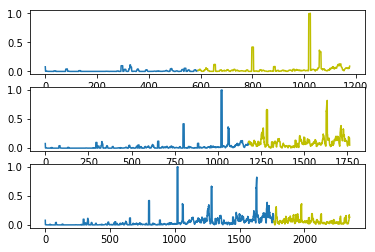

In [34]:
X = [f for f in x_normed]  #use normed_total_loccs column
splits = TimeSeriesSplit(n_splits=splits)  #choosing 3 splits
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
  train = [X[i] for i in train_index]
  test = [X[i] for i in test_index]
  print('Observations: %d' % (len(train) + len(test)))
  print('Training Observations: %d' % (len(train)))
  print('Testing Observations: %d' % (len(test)))
  pyplot.subplot(310 + index)
  pyplot.plot(train)
  pyplot.plot([None for i in train] + [x for x in test], 'y')
  index += 1
pyplot.show()


## First model - straight up ANN

In [0]:
def ann_test(model, test_x, sequence_size):
  
  print('Testing model')
  generator = TimeseriesGenerator(test_x, test_x, length=sequence_size, batch_size=1)
  predictions = []
  for  x,y in generator:
    #chunk = np.expand_dims(x, axis=0)
    chunk = x
    yhat = model.predict(chunk, verbose=0)
    predictions.append((yhat, y, abs(yhat-y)))  #(prediction, actual, diff)
  print('model ready to go')
  return predictions

### Reminder that k models will be trained and tested.

Where k = splits (set at top of notebook).

See graph above for the days that are included for each. Note only the last model takes into account the entire span of days.

In [37]:

ann_model_predictions = []

for train_indices, test_indices in splits.split(x_normed[:-averaging_size]):
  test_x = [x_normed[i] for i in test_indices]
  print('\t Testing:  ' + str((test_indices[0], test_indices[-1])))
  
  predictions = ann_test(model,  test_x, sequence_size)

  ann_model_predictions.append(predictions)  #list of (yhat, actual) for each feature in test



	 Testing:  (586, 1171)
Testing model
model ready to go
	 Testing:  (1172, 1757)
Testing model
model ready to go
	 Testing:  (1758, 2343)
Testing model
model ready to go


###Plot the abs differences bewteen predicted and actual in terms of k-day averages of lines of code changed.

In [38]:
## Plot abs(predicted-actual)

%matplotlib inline
from matplotlib import pyplot as plt


# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print( "Current size:", fig_size)

# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

def basic_plot(value_list, xlabel, ylabel):
  the_mean = np.mean(value_list)
  the_std = np.std(value_list)
  length = len(value_list)
  plt.plot(value_list)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.title('mean='+str(the_mean)[:5]+' std='+str(the_std)[:5])
  plt.fill_between(list(range(len(value_list))), [the_mean+the_std]*length, [the_mean-the_std]*length, alpha = 0.1, color='red', edgecolor='green', linewidth=1)
  plt.plot([the_mean+the_std]*length, label='std', linestyle='-', color='green', linewidth=1)
  plt.plot([the_mean]*length, label='Mean', linestyle='--', color='red')
  plt.plot([the_mean-the_std]*length, label='std', linestyle='-', color='green', linewidth=1)
  plt.show()


Current size: [6.0, 4.0]


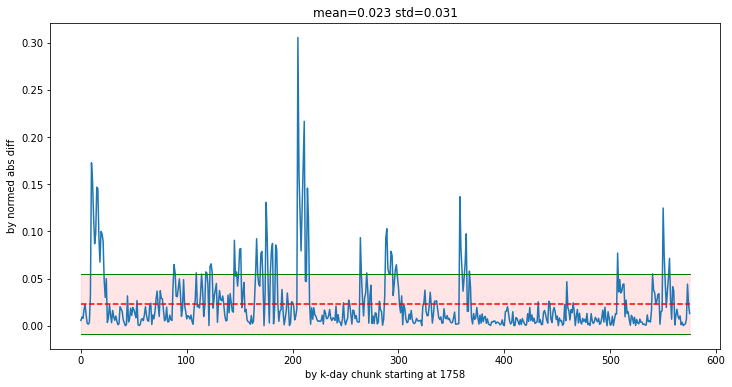

In [39]:
diffs = [d[0] for y,a,d in ann_model_predictions[-1]]  #need [0] to strip array off
basic_plot(diffs, 'by k-day chunk starting at '+str(test_indices[0]), 'by normed abs diff')

### Show for unnormed

Just because it is easier to see actual lines of code on y axis.

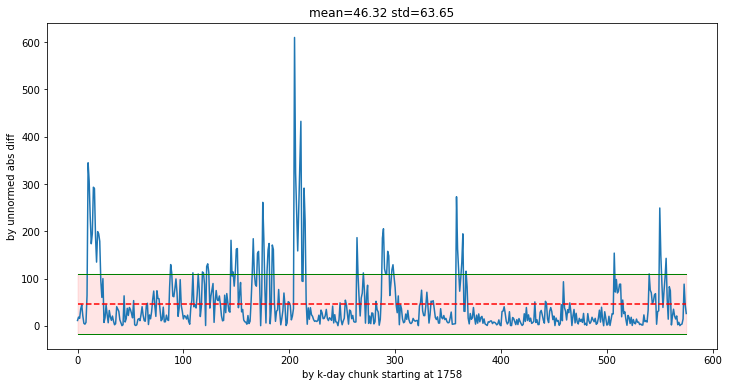

In [40]:
diffs = [unnorm(d[0]) for y,a,d in ann_model_predictions[-1]]  #need [0] to strip array off
basic_plot(diffs, 'by k-day chunk starting at '+str(test_indices[0]), 'by unnormed abs diff')

### Percentage of differences below mean difference

In [41]:
the_mean = np.mean(diffs)
sum([1 for d in diffs if d<the_mean])/len(diffs)

0.703125

### Mean Squared Error

In [42]:
from sklearn.metrics import mean_squared_error
mean_squared_error([unnorm(a[0]) for y,a,d in ann_model_predictions[-1]], [unnorm(y[0]) for y,a,d in ann_model_predictions[-1]])

6198.170036531806

###Check out binning

Post-hoc look at binning. Bin both predicted and actual and see how they match up.

Note could also set up model to be categorical and have it predict bins directly through one-hot encoding and softmax final layer.

In [0]:
normed_mean = np.mean(x_normed)
normed_std = np.std(x_normed)

bins = [normed_mean, normed_mean+normed_std, max(x_normed)]  #below average, above average, way above average

In [0]:
binned_results = []
for y,a,d in ann_model_predictions[-1]:
  for j,b in enumerate(bins):
    if y<b:
      yb = j
      break
      
  for j,b in enumerate(bins):
    if a<b:
      ab = j
      break
      
  binned_results.append((yb, ab))
      
  

In [45]:
for i in range(len(bins)):
  for j in range(len(bins)):
    print((i,j,binned_results.count((i,j))))

(0, 0, 333)
(0, 1, 89)
(0, 2, 3)
(1, 0, 12)
(1, 1, 100)
(1, 2, 30)
(2, 0, 0)
(2, 1, 0)
(2, 2, 9)


### Way to read above

Take this set of results as an example.

<pre>
(0, 0, 295)
(0, 1, 34)
(0, 2, 3)
(1, 0, 47)
(1, 1, 140)
(1, 2, 5)
(2, 0, 0)
(2, 1, 10)
(2, 2, 38)
</pre>

If you view predicting the spikes (bin 2) as key, then the results show false negative 3+5 times (14%), perhaps the 3 being the worst: predicting below avearage and actual spike instead. It shows false positives 0+10 times (18%). It is correct 38 times ( 68%).

Code below gives accuracy for each bin.

In [46]:

for i in range(len(bins)):
  errors = 0
  for j in range(len(bins)):
    if i==j:
      correct = binned_results.count((i,i))
      continue
    errors += binned_results.count((i,j))
  print((i, correct/(correct+errors)))
  
  

(0, 0.7835294117647059)
(1, 0.704225352112676)
(2, 1.0)


Values from spack-trained model:
<pre>
(0, 0.8412698412698413)
(1, 0.7834394904458599)
(2, 0.7804878048780488)
</pre>

### Full binning accuracy

In [47]:
sum([1 for y,a in binned_results if y==a])/len(binned_results)  #percentage correct binning

0.7673611111111112